In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import (GridSearchCV, cross_val_score, train_test_split)
from sklearn.preprocessing import StandardScaler

### Відкриття даних

In [2]:
data = pd.read_csv('data/winequality-white.csv', sep = ';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### Знаходження кореляцій

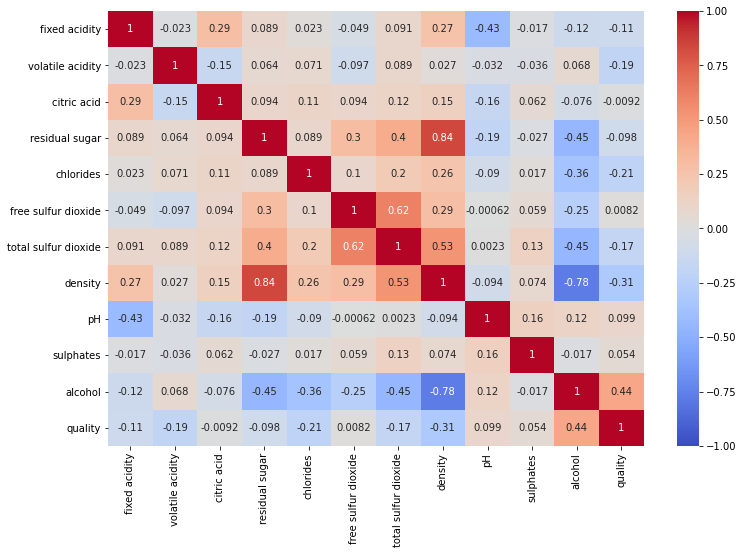

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');

### Виділення цілевої ознаки, розбиття вибірки на тестову (70%) та відкладену. Маштабування за допомогою StandardScaler 

In [5]:
X,y = data.drop('quality', axis = 1).values, data.quality.values
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size = .7, random_state = 17)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout) 

#### Загальна ф-ція

In [6]:
def train_holdout_report(model, X_train_scaled, y_train, X_holdout_scaled, y_holdout, feature_names, forest = False):
    """Вивід MSE та табличних кореляцій для лінійних моделей та regression forest"""
    %time
    model.fit(X_train_scaled, y_train)
    
    print(f'MSE={np.sqrt(mean_squared_error(y_holdout, model.predict(X_holdout_scaled)))}')             
    print('Model coefficients:')
    
    coef_name = 'Importance' if forest else 'Coef' 
    coef = model.feature_importances_ if forest else model.coef_
    print(pd.DataFrame(coef, feature_names, columns = [coef_name]).sort_values(by=coef_name, ascending = False))

### Лінійна регресія

In [7]:
# Відображення ознак із найбільшим впливом на середню квадратичну поилку
# Такою виявилась "residual sugar"
# Деякі ознаки ("citric acid", "volatile acidity", "density") дають від'ємні значення --- мультиколінеарність

linreg = LinearRegression()
train_holdout_report(linreg, X_train_scaled, y_train, X_holdout_scaled, y_holdout, feature_names = data.columns[:-1])

Wall time: 0 ns
MSE=0.7643607199748391
Model coefficients:
                          Coef
residual sugar        0.538164
pH                    0.150036
alcohol               0.129533
fixed acidity         0.097822
sulphates             0.062053
free sulfur dioxide   0.042180
total sulfur dioxide  0.014304
chlorides             0.008127
citric acid          -0.000183
volatile acidity     -0.192260
density              -0.665720


### Lasso - регресія (α=0.01, random_state = 17)

In [8]:
lasso = Lasso(alpha =.001, random_state=17)
train_holdout_report(lasso, X_train_scaled, y_train, X_holdout_scaled, y_holdout, feature_names = data.columns[:-1])

Wall time: 0 ns
MSE=0.7622860596653876
Model coefficients:
                          Coef
residual sugar        0.498318
alcohol               0.156379
pH                    0.137682
fixed acidity         0.081947
sulphates             0.058145
free sulfur dioxide   0.044016
total sulfur dioxide  0.009627
chlorides             0.003970
citric acid           0.000000
volatile acidity     -0.191600
density              -0.603651


In [9]:
# Пошук для lassoCv - регресії оптимальної моделі за alpha (із сітки вибирається оптимальна)
alphas = np.logspace(-6, 2, 200)
lassoCV = LassoCV(alphas=alphas, random_state=17)
train_holdout_report(lassoCV, X_train_scaled, y_train, X_holdout_scaled, y_holdout, feature_names = data.columns[:-1])
print(f'Best α = {lassoCV.alpha_}')

Wall time: 0 ns
MSE=0.7637392276072138
Model coefficients:
                          Coef
residual sugar        0.526883
pH                    0.146549
alcohol               0.137115
fixed acidity         0.093295
sulphates             0.060939
free sulfur dioxide   0.042698
total sulfur dioxide  0.012969
chlorides             0.006933
citric acid          -0.000000
volatile acidity     -0.192049
density              -0.648161
Best α = 0.0002833096101839324


### Модель RandomForestRegressor

In [10]:
r_forest = RandomForestRegressor(random_state=17)
train_holdout_report(r_forest, X_train_scaled, y_train, X_holdout_scaled, y_holdout, feature_names = data.columns[:-1], 
                     forest=True)

Wall time: 0 ns
MSE=0.6096209929965017
Model coefficients:
                      Importance
alcohol                 0.247273
volatile acidity        0.125960
free sulfur dioxide     0.116562
pH                      0.071950
residual sugar          0.070903
total sulfur dioxide    0.067204
chlorides               0.063729
fixed acidity           0.061918
sulphates               0.059056
citric acid             0.058904
density                 0.056540


In [11]:
# Пошук оптимальної моделі RandomForestRegressor

forest_params = {'max_depth': list(range(10, 20)), 
                 'min_samples_leaf': list(range(3, 5)),
                 'max_features': list(range(5, 8))}

forest_grid = GridSearchCV(r_forest, forest_params, cv=2, n_jobs=-1, verbose=True)
forest_grid.fit(X_train_scaled, y_train)

print(f'MSE={np.sqrt(mean_squared_error(y_holdout, forest_grid.predict(X_holdout_scaled)))}')             
print(f'Best model: {forest_grid.best_params_}, best score: {forest_grid.best_score_}')

Fitting 2 folds for each of 60 candidates, totalling 120 fits
MSE=0.6232531971055132
Best model: {'max_depth': 17, 'max_features': 5, 'min_samples_leaf': 3}, best score: 0.4095895241138991


In [12]:
# Застосунок найкращих параметрів до пошуку MSE
r_forest = RandomForestRegressor(max_depth =17, max_features=5,min_samples_leaf=3 ,random_state=17)
train_holdout_report(r_forest, X_train_scaled, y_train, X_holdout_scaled, y_holdout, feature_names = data.columns[:-1], 
                     forest=True)

Wall time: 0 ns
MSE=0.6232531971055132
Model coefficients:
                      Importance
alcohol                 0.230021
volatile acidity        0.118798
free sulfur dioxide     0.110044
density                 0.091583
residual sugar          0.071638
chlorides               0.070065
total sulfur dioxide    0.069567
pH                      0.068783
citric acid             0.061015
fixed acidity           0.058080
sulphates               0.050406
